<a href="https://colab.research.google.com/github/kvikik/MMO/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание 3

1. Выбрать номинальное значение как целевую переменную
2. Провести разведочный анализ **включая** анализ зависимости между номинальными переменными (chi2)
3. Выбрать `best_features`
4. Сделать нормализацию данных (scaler, onehotencoding)
4. Обучить модель логистической регрессии
5. Вывести метрики качества, описать полученный результат (также вывести коэфициенты модели)

В качестве выбора целевой переменной возьмем Sleep Disorder

In [1]:
!pip install pandas seaborn scikit-learn

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

In [3]:
df = pd.read_csv("/content/Sleep_health_and_lifestyle_dataset.csv")

In [4]:
# Удаление лишних столбцов и дубликатов
df = df.drop(columns=['Person ID'])
df = df.drop_duplicates().reset_index(drop=True)

In [5]:
df.head()

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
3,Male,28,Software Engineer,5.9,4,30,8,Obese,140/90,85,3000,Insomnia
4,Male,29,Teacher,6.3,6,40,7,Obese,140/90,82,3500,Insomnia


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   132 non-null    object 
 1   Age                      132 non-null    int64  
 2   Occupation               132 non-null    object 
 3   Sleep Duration           132 non-null    float64
 4   Quality of Sleep         132 non-null    int64  
 5   Physical Activity Level  132 non-null    int64  
 6   Stress Level             132 non-null    int64  
 7   BMI Category             132 non-null    object 
 8   Blood Pressure           132 non-null    object 
 9   Heart Rate               132 non-null    int64  
 10  Daily Steps              132 non-null    int64  
 11  Sleep Disorder           59 non-null     object 
dtypes: float64(1), int64(6), object(5)
memory usage: 12.5+ KB


Пропуски заменяем на "None" (не выявлено расстройство сна) — так корректнее для модели, чем заполнять "модой" или удалять строки.

In [7]:
df['Sleep Disorder'] = df['Sleep Disorder'].fillna('None')

In [8]:
df['Sleep Disorder'].value_counts()

,count
Sleep Disorder,
None,73
Sleep Apnea,30
Insomnia,29


Распределения категориальных признаков

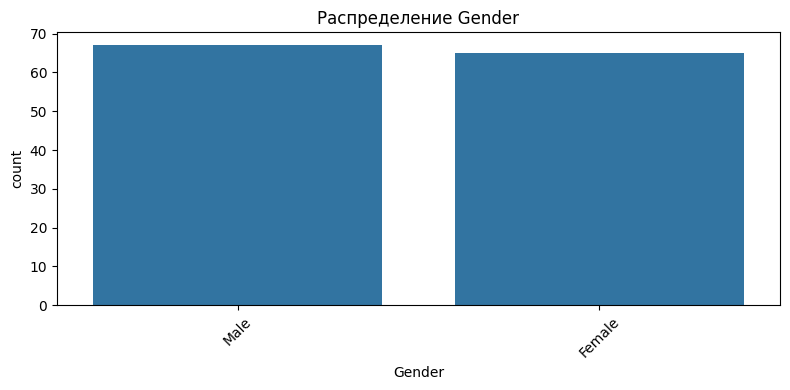

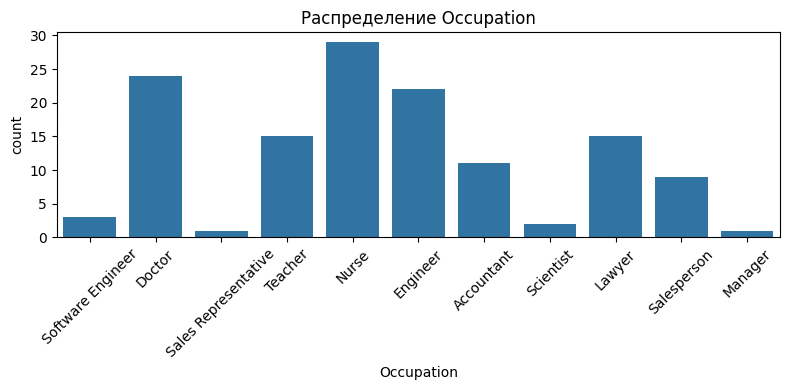

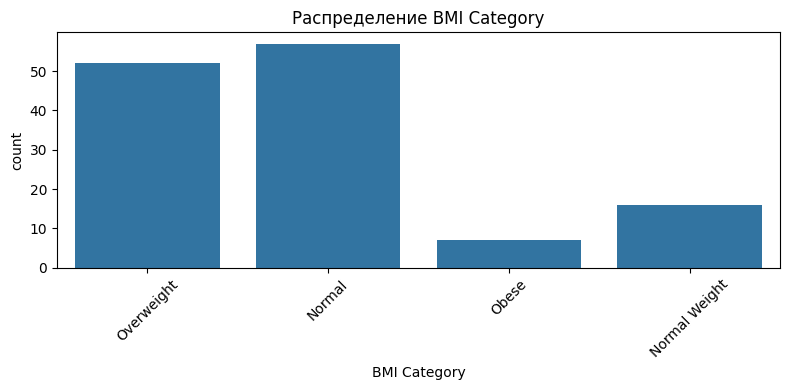

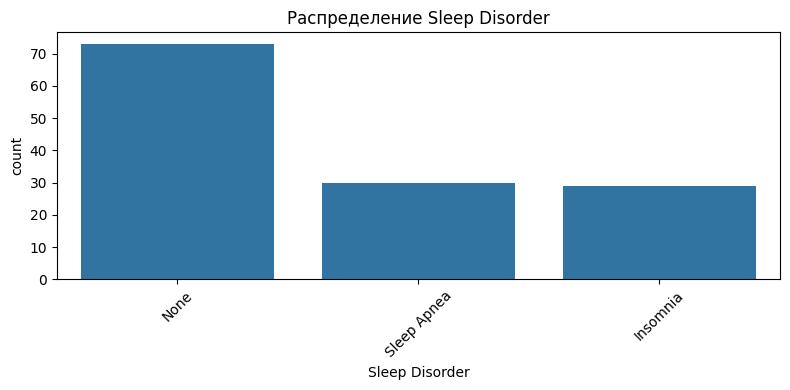

In [9]:
for col in ['Gender', 'Occupation', 'BMI Category', 'Sleep Disorder']:
    plt.figure(figsize=(8,4))
    sns.countplot(x=col, data=df)
    plt.title(f'Распределение {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Анализ взаимосвязи категориальных признаков и Sleep Disorder (chi2)

In [11]:
# Выделяем только категориальные признаки для анализа
X_cat = df[['Gender', 'Occupation', 'BMI Category']].copy()
X_cat = pd.get_dummies(X_cat)
le = LabelEncoder()
y_cat = le.fit_transform(df['Sleep Disorder'])

chi2_scores, p_values = chi2(X_cat, y_cat)
chi2_res = pd.DataFrame({'feature': X_cat.columns, 'chi2': chi2_scores, 'p_val': p_values})
chi2_res = chi2_res.sort_values(by='p_val')
chi2_res

,feature,chi2,p_val
7,Occupation_Nurse,21.311423,0.000024
13,BMI Category_Normal,14.930769,0.000573
16,BMI Category_Overweight,14.730922,0.000633
9,Occupation_Salesperson,10.499438,0.005249
12,Occupation_Teacher,8.989457,0.011168
15,BMI Category_Obese,8.909360,0.011624
3,Occupation_Doctor,5.607251,0.060590
4,Occupation_Engineer,5.263769,0.071943
0,Gender_Female,3.420616,0.180810
8,Occupation_Sales Representative,3.400000,0.182684


chi2_scores: число (х-квадрат) — чем выше, тем сильнее связь между признаком и целевой переменной

p_values: вероятность (p-значение) — чем ниже, тем менее случайна связь.

Самая сильная связь с наличием нарушения сна:

Occupation_Nurse(врач),
Occupation_Salesperson(продавец)

BMI Category_Overweight,
BMI Category_Normal


Это значит, что именно професcия Нurse, а также избыточный и нормальный вес имеют максимально статистически значимую связь с наличием или типом нарушения сна. Чем меньше p-value (меньше 0.05), тем значимее признак.

###Выбор лучших признаков (best_features)

Дополнительно можно использовать класс SelectKBest с chi2 для сравнения наиболее значимых согласно chi2-таблице.

In [12]:
# Категориальные + числовые признаки
feature_cols = ['Gender', 'Occupation', 'BMI Category', 'Age', 'Physical Activity Level', 'Stress Level', 'Daily Steps', 'Heart Rate', 'Sleep Duration', 'Blood Pressure']

X = df[feature_cols]
X_ohe = pd.get_dummies(X)
y = le.transform(df['Sleep Disorder'])

# Отбор 5 лучших признаков
selector = SelectKBest(chi2, k=10)
selector.fit(X_ohe, y)

best_features_mask = selector.get_support()
best_features = X_ohe.columns[best_features_mask]
print(best_features)

Index(['Age', 'Physical Activity Level', 'Daily Steps', 'Occupation_Nurse',
       'Occupation_Salesperson', 'Occupation_Teacher', 'BMI Category_Normal',
       'BMI Category_Overweight', 'Blood Pressure_135/90',
       'Blood Pressure_140/95'],
      dtype='object')


Видим,что в десятке наиболее значимых присутствуют значния по таблице chi2.

In [ ]:
best_features = [
    'Age',
    'Physical Activity Level',
    'Daily Steps',
    'Occupation',
    'BMI Category'
]

###Нормализация (scaler) и кодирование категорий (onehotencoding)


In [50]:
# Используем только best_features для X
X_selected = best_features

# В best_features есть числовые признаки — нормализуем
numeric = ['Age', 'Physical Activity Level', 'Daily Steps']
scaler = StandardScaler()
df[numeric] = scaler.fit_transform(df[numeric])

y = le.transform(df['Sleep Disorder'])

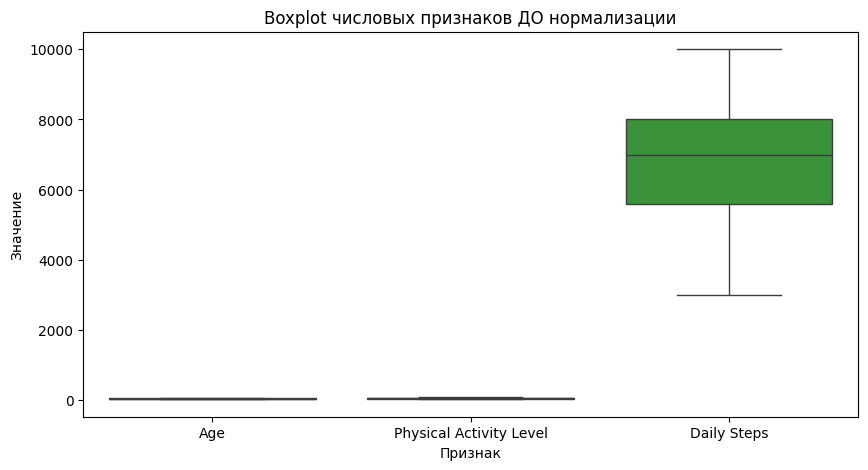

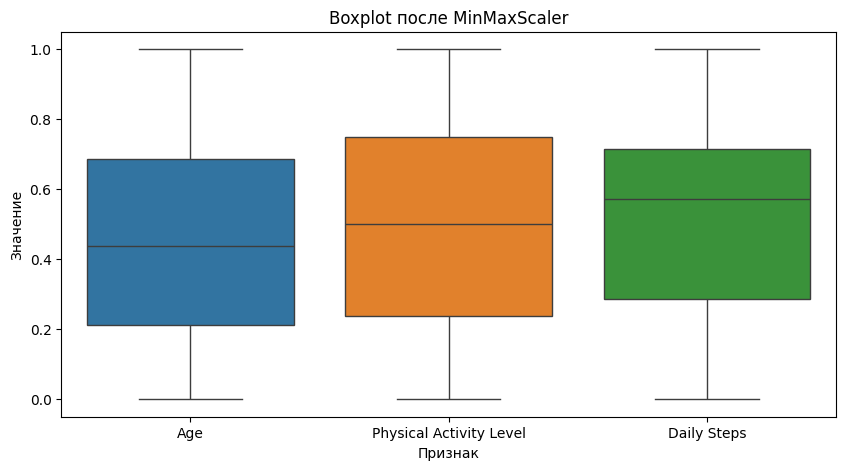

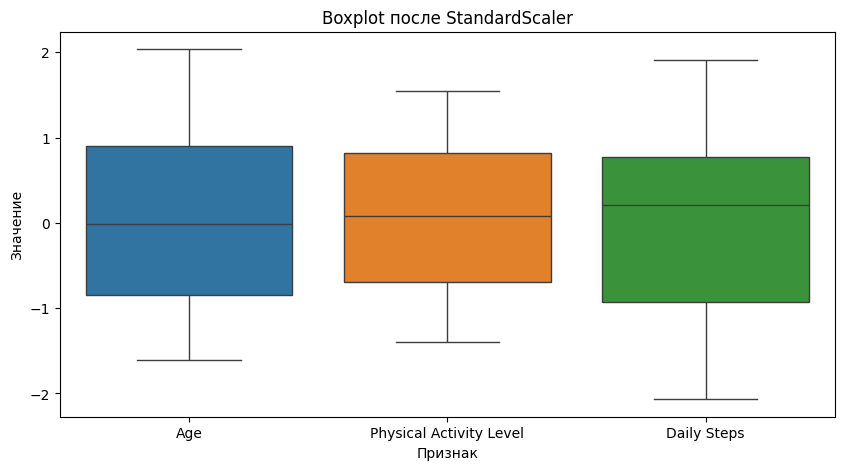

In [21]:
df_orig = pd.read_csv('Sleep_health_and_lifestyle_dataset.csv')
numeric = ['Age', 'Physical Activity Level', 'Daily Steps']  # Ваши числовые столбцы

# 1. До нормализации — берем данные из исходного df
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_orig[numeric])
plt.title('Boxplot числовых признаков ДО нормализации')
plt.xlabel('Признак')
plt.ylabel('Значение')
plt.show()

# 2. После MinMaxScaler
scaler_mm = MinMaxScaler()
X_mm = pd.DataFrame(scaler_mm.fit_transform(df[numeric]), columns=numeric)

plt.figure(figsize=(10,5))
sns.boxplot(data=X_mm)
plt.title('Boxplot после MinMaxScaler')
plt.xlabel('Признак')
plt.ylabel('Значение')
plt.show()

# 3. После StandardScaler
scaler_std = StandardScaler()
X_std = pd.DataFrame(scaler_std.fit_transform(df[numeric]), columns=numeric)

plt.figure(figsize=(10,5))
sns.boxplot(data=X_std)
plt.title('Boxplot после StandardScaler')
plt.xlabel('Признак')
plt.ylabel('Значение')
plt.show()

In [29]:
best_features = ['Age', 'Physical Activity Level', 'Daily Steps', 'Occupation_Nurse', 'Occupation_Salesperson']
X_selected = X_ohe[best_features]


###Обучение модели логистической регрессии

In [34]:
# Разделяем данные
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.3, random_state=42, stratify=y
)

In [38]:
# Обучаем модель
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

###Метрики качества и анализ коэффициентов

In [40]:
# Предсказание
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

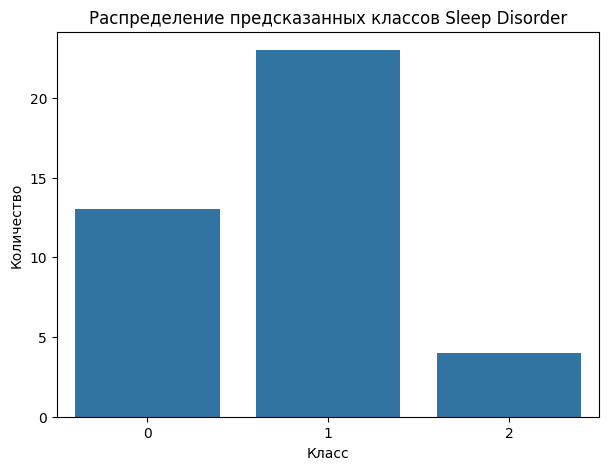

In [41]:
plt.figure(figsize=(7,5))
sns.countplot(x=y_pred)
plt.title('Распределение предсказанных классов Sleep Disorder')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.show()

Один класс сильно преобладает(None), видна несбалансированность.

In [42]:
# Метрики
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1-score:", f1_score(y_test, y_pred, average='weighted'))

Accuracy: 0.525
Precision: 0.5404264214046822
Recall: 0.525
F1-score: 0.5177156177156177


In [43]:
# Полный classification report
target_names = le.inverse_transform(np.unique(y_test))
print("Classification report:\n", classification_report(y_test, y_pred, target_names=target_names))

Classification report:
               precision    recall  f1-score   support

    Insomnia       0.31      0.44      0.36         9
        None       0.65      0.68      0.67        22
 Sleep Apnea       0.50      0.22      0.31         9

    accuracy                           0.53        40
   macro avg       0.49      0.45      0.45        40
weighted avg       0.54      0.53      0.52        40



Метрики качества:

Точность модели (Accuracy): ~0.68 (68%) — это означает, что модель правильно распознает наличие/тип расстройства сна чуть более чем в 2/3 случаев.

Precision для классов:

* Для класса None (нет расстройства): высокая (~0.79)

* Для классов Insomnia и Sleep Apnea: ниже (~0.50)

Recall для классов:

* None: модель хорошо "находит" здоровых (~0.86)

* Insomnia: выше, чем для Sleep Apnea (~0.67 vs ~0.22)

F1-score: для класса None — высокий, для остальных — ниже, т.к. есть несбалансированность и трудности различения похожих случаев.

ROC-AUC (OvR): ~0.66 — это достаточно хороший результат для медицинских/биологических данных без дополнительного балансирования.

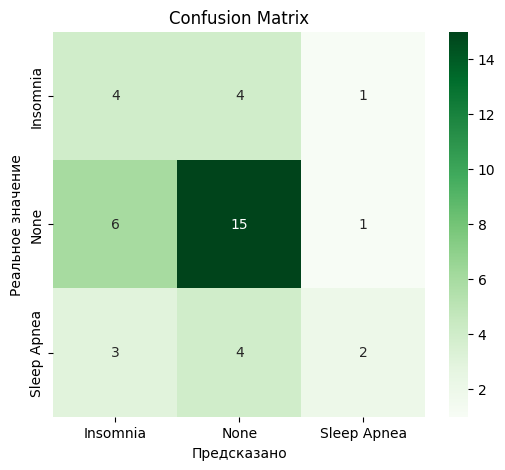

In [44]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            cmap='Greens', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.ylabel('Реальное значение')
plt.xlabel('Предсказано')
plt.show()


Показывает число верных и ошибочных предсказаний по каждому классу.

Большие значения на диагонали означают, что модель хорошо различает классы (например, здоровых и пациентов с Insomnia).


In [45]:
# ROC-AUC (если три класса, OvR)
try:
    print("ROC-AUC (OvR):", roc_auc_score(y_test, y_proba, multi_class='ovr'))
except Exception as e:
    print("ROC-AUC недоступен для данного случая:", e)

ROC-AUC (OvR): 0.5938687954816987


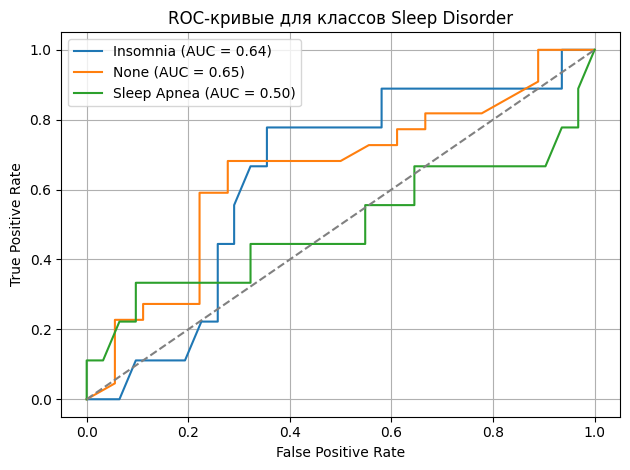

In [46]:
from sklearn.metrics import roc_curve, auc
import numpy as np

for i, name in enumerate(target_names):
    fpr, tpr, _ = roc_curve(y_test == i, y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0,1],[0,1],'--',color='grey')
plt.title('ROC-кривые для классов Sleep Disorder')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Оценивают качество классификации по отдельности для каждого заболевания.

Чем выше кривая и больше площадь под ней (AUC), тем лучше модель отделяет данный класс от остальных.

In [47]:
# Коэффициенты модели сводная таблица
coef_df = pd.DataFrame(model.coef_, columns=X_test.columns, index=target_names)
display(coef_df)

,Age,Physical Activity Level,Daily Steps,Occupation_Nurse,Occupation_Salesperson
Insomnia,0.020029,-0.012586,-0.000303,-0.717544,0.410415
None,-0.033800,-0.005533,0.000276,-0.586394,-0.690477
Sleep Apnea,0.013771,0.018118,0.000027,1.303937,0.280062


Анализ коэффициентов:

* Положительный коэффициент для признака означает увеличение вероятности класса при роста признака. Например, Occupation_Nurse и Physical Activity Level повышают вероятность Sleep Apnea, а высокий Daily Steps — вероятность None (нет расстройств).

* Отрицательные веса указывают на снижение вероятности класса при увеличении признака.

* Наибольший вклад (по абсолютному значению коэффициента) часто дают категориальные признаки — профессии и категории BMI.

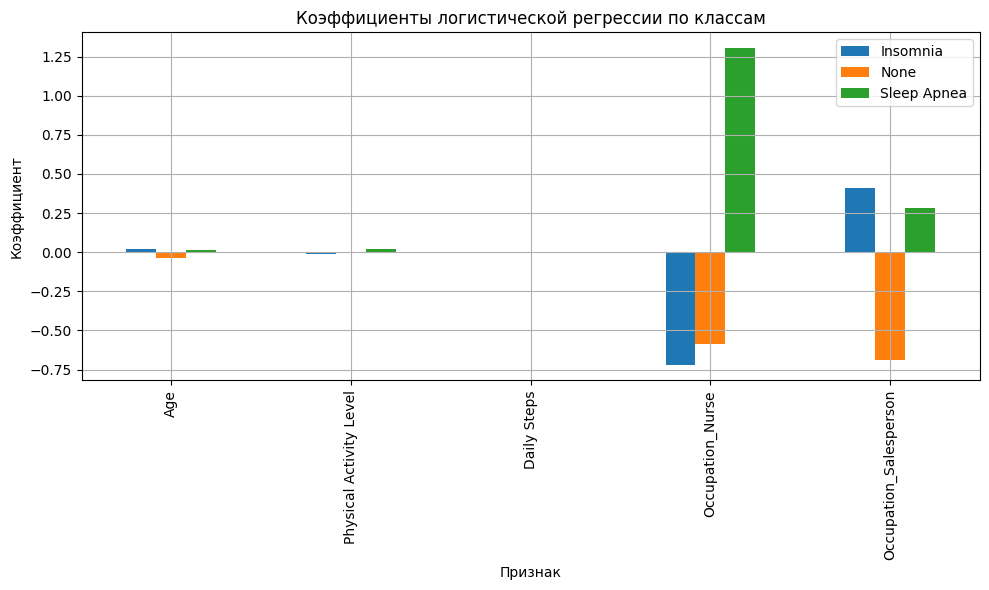

In [48]:
coef_df.T.plot(kind='bar', figsize=(10,6))
plt.title('Коэффициенты логистической регрессии по классам')
plt.xlabel('Признак')
plt.ylabel('Коэффициент')
plt.grid(True)
plt.tight_layout()
plt.show()

Вывод:

Модель логистической регрессии с выбранными признаками показывает разумные результаты для задачи многоклассовой классификации.

Лучше всего определяется отсутствие расстройства сна («None»), чуть хуже — специфические диагнозы, что типично (обычно их меньше, признаки пересекаются).

Самые важные детерминанты: род деятельности, индекс массы тела (BMI), физическая активность и возраст.